In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

torch.set_printoptions(sci_mode = False)

# Reproducing Jidling et al. 2017 5.1 experiments

- Matlab code is available [here](https://github.com/carji475/linearly-constrained-gaussian-processes/tree/master/simulation-example)
    - [simulation_fieldplots.m](https://github.com/carji475/linearly-constrained-gaussian-processes/blob/master/simulation-example/simulation_fieldplots.m) produces Figure 2
    - [simulation_study.m](https://github.com/carji475/linearly-constrained-gaussian-processes/blob/master/simulation-example/simulation_study.m) produces Figure 3 (a)

Details:
- The mean over 50 draws is taken to determine the difference 

In [213]:
# 20 discretisation over domain [0, 4]
spacing = 20
# overwrite to have higher detail
# spacing = 200

N_grid = spacing**2

x1 = np.linspace(0, 4, spacing)
x2 = np.linspace(0, 4, spacing)

# Field (2d grid)
X1, X2 = np.meshgrid(x1, x2)

sigma = 10**(-4) # same as 1e-4
a = 0.01

In [214]:
def F1F2_function(x1, x2, a = a):
    X1X2 = np.multiply(x1, x2)
    F1 = np.exp(- a * X1X2) * ((a * x1 * np.sin(X1X2)) - (x1 * np.cos(X1X2)))
    F2 = np.exp(- a * X1X2) * ((x2 * np.cos(X1X2)) - (a * x2 * np.sin(X1X2)))
    return F1, F2

In [215]:
F1, F2 = F1F2_function(X1, X2)

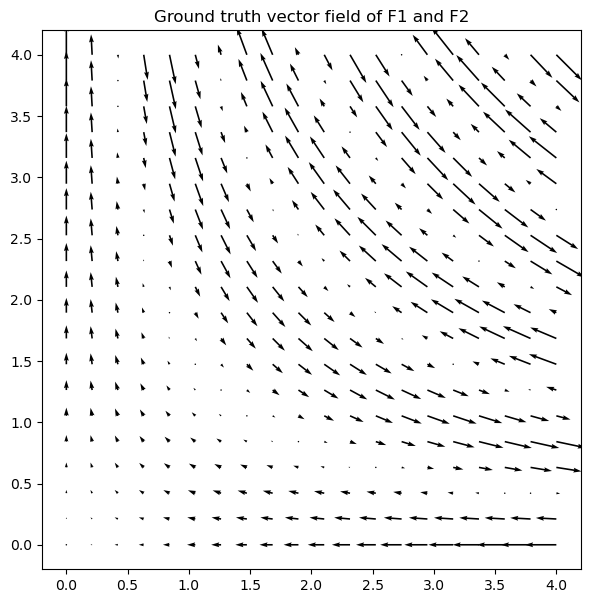

In [219]:
# creating plot
fig, ax = plt.subplots(figsize = (7, 7))

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, F1, F2)

ax.set_aspect('equal')

plt.title('Ground truth vector field of F1 and F2')
 
# show plot
plt.show()

# Check that this is divergence free

- Calculate divergence

In [220]:
# Mask to randomly select 50 datapoints

# np.gradient default step size is 1
# dy = 1
# True
dx1, dx2 = X1[0,1] - X1[0,0], X2[1,0] - X2[0,0]
print(dx1, dx2)

# stretched
# dx, dy = 4, 4
divergence = np.gradient(F1, dx1, axis = 1) + np.gradient(F2, dx2, axis = 0)
# We are exacly reprocing matlab code
print(np.max(np.abs(divergence)))

# syemmetry: as a sum it is non divergent: cancelling out
np.sum(divergence)

0.21052631578947367 0.21052631578947367
4.05695232274758


0.0

in Numpy, the x axis is the last axis instead of the first axis. When using np.gradient(x, axis=0), Numpy actually gives the gradient of y direction (when x is a 2d array).
https://stackoverflow.com/questions/11435809/compute-divergence-of-vector-field-using-python

In [221]:
# This function actually works for xy ordering
# based on matlab code (xy ordering)

def calc_divergence(f, dx, dy):
    """
    Computes the divergence of the vector field f, corresponding to dFx/dx + dFy/dy + ...
    :param f: List of 2 ndarrays
    :return: Single ndarray of the same shape as each of the items in f, which corresponds to a scalar field
    """
    return np.ufunc.reduce(np.add, [np.gradient(f[0], dx, axis = 1), np.gradient(f[1], dy, axis = 0)])

(array([  2.,   0.,   1.,   2.,   1.,   3.,  26., 330.,  26.,   3.,   1.,
          2.,   1.,   0.,   2.]),
 array([-4.05695232, -3.51602535, -2.97509837, -2.43417139, -1.89324442,
        -1.35231744, -0.81139046, -0.27046349,  0.27046349,  0.81139046,
         1.35231744,  1.89324442,  2.43417139,  2.97509837,  3.51602535,
         4.05695232]),
 <BarContainer object of 15 artists>)

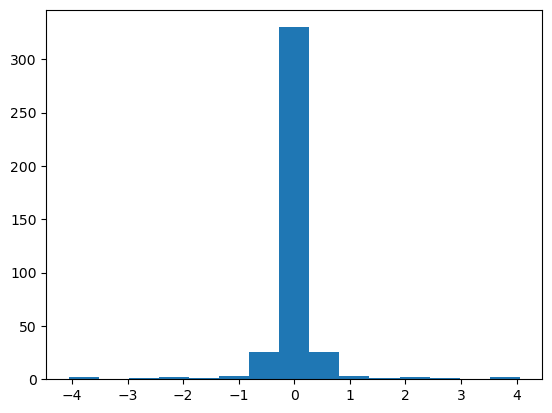

In [222]:
# edge artifacts produce some errors
div = calc_divergence([F1, F2], dx1, dx2)
plt.hist(div.reshape(20*20), bins = 15)

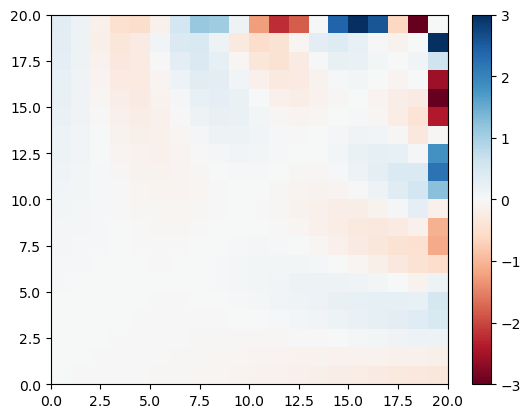

In [11]:
plt.pcolormesh(div, cmap = 'RdBu', vmin = -3, vmax = 3)
# same as
# plt.pcolormesh(np.gradient(F1, axis = 1) + np.gradient(F2, axis = 0), cmap = 'RdBu', vmin = -3, vmax = 3)
plt.colorbar()
plt.show()

From Matlab: edge artifacts

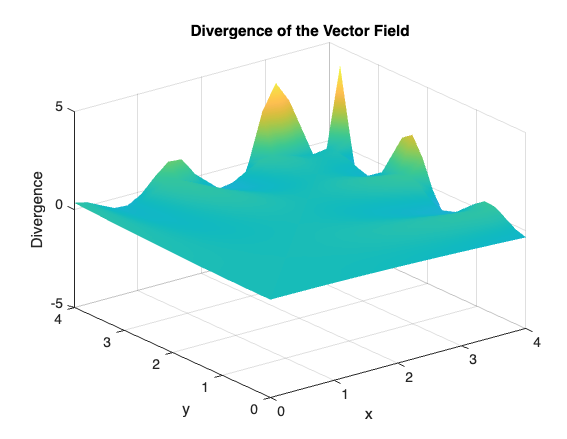

# Component wise divergence

TODO:
- Account for step size

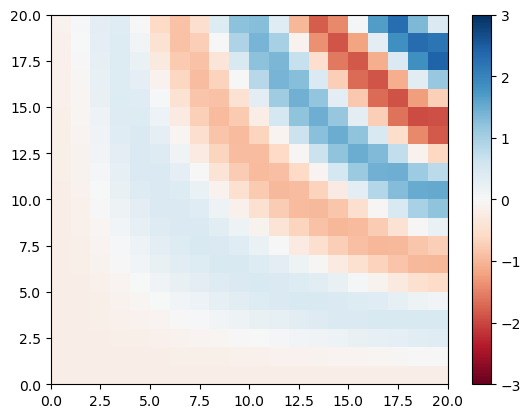

In [12]:
plt.pcolormesh(np.gradient(F1, axis = 1), cmap = 'RdBu', vmin = -3, vmax = 3)
plt.colorbar()
plt.show()

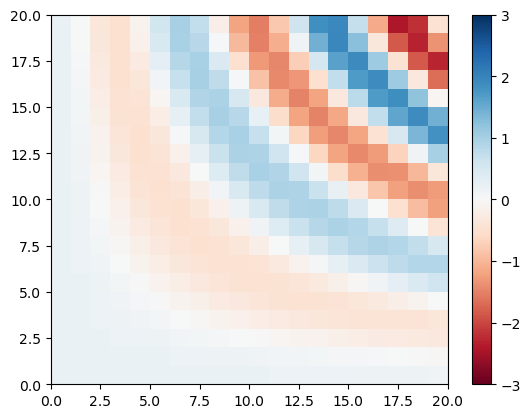

In [13]:
plt.pcolormesh(np.gradient(F2, axis = 0), cmap = 'RdBu', vmin = -3, vmax = 3)
plt.colorbar()
plt.show()

# Random selection of points

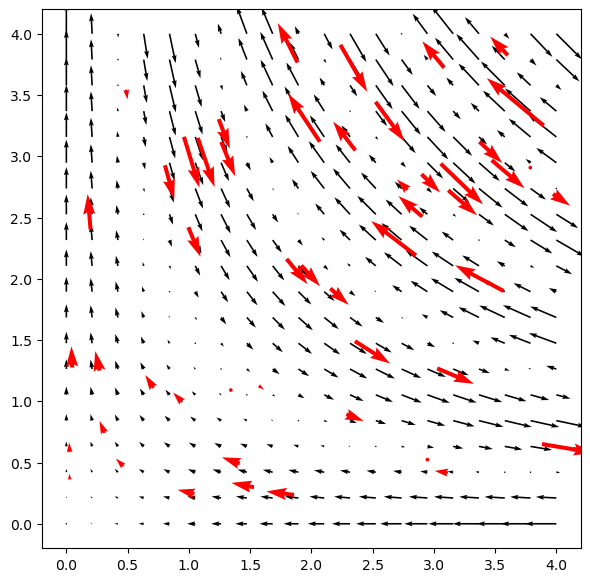

In [105]:
# Draw 50, 2 random numbers between 0 and 1 (for x and y axis), scale by 4 to stretch domain
x1x2_train = np.random.rand(50, 2) * 4

# Pass both columns into the function to get true training values
F1_train, F2_train = F1F2_function(x1x2_train[:, 0][:, np.newaxis], x1x2_train[:, 1][:, np.newaxis])

# add noise: scale is sd, not var!!
F1_train += np.random.normal(0, sigma, x1x2_train.shape[0])[:, np.newaxis]
F2_train += np.random.normal(0, sigma, x1x2_train.shape[0])[:, np.newaxis]

y_train = torch.cat((torch.tensor(F1_train), torch.tensor(F2_train)), dim = 1)

# creating plot
fig, ax = plt.subplots(figsize = (7, 7))

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, F1, F2)
ax.quiver(x1x2_train[:, 0], x1x2_train[:, 1], F1_train, F2_train, color = 'red')

ax.set_aspect('equal')
 
# show plot
plt.show()

In [104]:
y_train = torch.cat((torch.tensor(F1_train), torch.tensor(F2_train)), dim = 1)

# TODO

- visualise divergence as surface (plotly?!)
- Compare divergence to a regular interpolation with a GP

### Covariance function for squared exponential

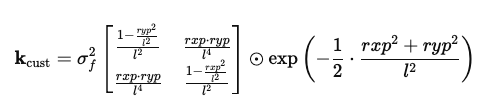

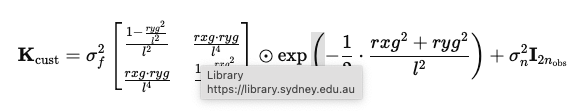

Squared exponential derivates  
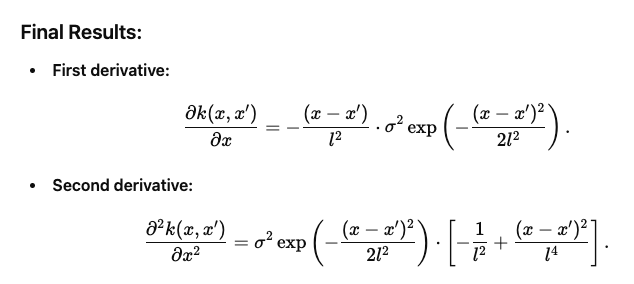

In [91]:
# x1 test locations (flat) - torch.Size([400])
x1_test = torch.tensor(X1).flatten()
x2_test = torch.tensor(X2).flatten()

# x1 test pariwise differences - torch.Size([400, 400])
x1_test_diff = x1_test.unsqueeze(1) - x1_test.unsqueeze(0)
x2_test_diff = x2_test.unsqueeze(1) - x2_test.unsqueeze(0)
x1_test = torch.tensor(X1).flatten()
x2_test = torch.tensor(X2).flatten()
print(x1_test.shape)

# Extra
x1p_x1p_diff = x1_test.unsqueeze(1) - x1_test.unsqueeze(0)
x2p_x2p_diff = x2_test.unsqueeze(1) - x2_test.unsqueeze(0)

x1_train = torch.tensor(x1x2_train)[:, 0]
x2_train = torch.tensor(x1x2_train)[:, 1]

# corresponds to rxg (x1 "given")
x1t_x1t_diff = x1_train.unsqueeze(1) - x1_train.unsqueeze(0)
# corresponds to ryg (x2 "given")
x2t_x2t_diff = x2_train.unsqueeze(1) - x2_train.unsqueeze(0)

# corresponds to rxp (x1 "given" and x1 "predivtive") - torch.Size([50, 400])
x1t_x1p_diff = x1_train.unsqueeze(1) - x1_test.unsqueeze(0)
# corresponds to ryp (x2 "given" and x2 "predivtive") - torch.Size([50, 400])
x2t_x2p_diff = x2_train.unsqueeze(1) - x2_test.unsqueeze(0)

torch.Size([400])


In [92]:
# HPs
# Compare against the matlab code: fix hypers
sigma_f = torch.tensor(0.7)
l = torch.tensor(0.7)
sigma_n = torch.tensor(0.01)

# K_train_train

Gram matrix

In [93]:
# Gram matrix
# K_train_train 

# elementwise
upper_left = (1 - x2t_x2t_diff.square().div(l**2)).div(l**2)
upper_right = torch.mul(x1t_x1t_diff, x2t_x2t_diff).div(l**4)
lower_left = upper_right
lower_right = (1 - x1t_x1t_diff.square().div(l**2)).div(l**2)

# Multiplier block - torch.Size([100, 100])
K_train_train_block = torch.cat((torch.cat((upper_left, upper_right), 1), torch.cat((lower_left, lower_right), 1)), 0)
# Add diagonal noise: - torch.Size([100, 100])
# plus, div -2, sigma_f_square()
K_train_train = sigma_f.square() * K_train_train_block.mul((x1t_x1t_diff.square() + x2t_x2t_diff.square()).div(-2 * l**2).exp().tile(2, 2))

K_train_train_noise = K_train_train + torch.eye(x1t_x1t_diff.shape[0] * 2) * sigma_n**2

# K_train_test

In [95]:
upper_left_cross = (1 - x2t_x2p_diff.square().div(l**2)).div(l**2)
upper_right_cross = torch.mul(x1t_x1p_diff, x2t_x2p_diff).div(l**4)
lower_left_cross = upper_right_cross
lower_right_cross = (1 - x1t_x1p_diff.square().div(l**2)).div(l**2)

K_train_test_block = torch.cat((torch.cat((upper_left_cross, upper_right_cross), 1), torch.cat((lower_left_cross, lower_right_cross), 1)), 0)

# lower k, no diag noise
K_train_test = sigma_f.square() * K_train_test_block.mul((x1t_x1p_diff.square() + x2t_x2p_diff.square()).div(-2 * l**2).exp().tile(2, 2))

# K_test_test

for variance

In [134]:
upper_left_testtest = (1 - x2p_x2p_diff.square().div(l**2)).div(l**2)
upper_right_testtest = torch.mul(x1p_x1p_diff, x2p_x2p_diff).div(l**4)
lower_left_testtest = upper_right_testtest
lower_right_testtest = (1 - x1p_x1p_diff.square().div(l**2)).div(l**2)

K_test_test_block = torch.cat((torch.cat((upper_left_testtest, upper_right_testtest), 1), torch.cat((lower_left_testtest, lower_right_testtest), 1)), 0)

K_test_test = sigma_f.square() * K_test_test_block.mul((x1p_x1p_diff.square() + x2p_x2p_diff.square()).div(-2 * l**2).exp().tile(2, 2))

# Cholesky

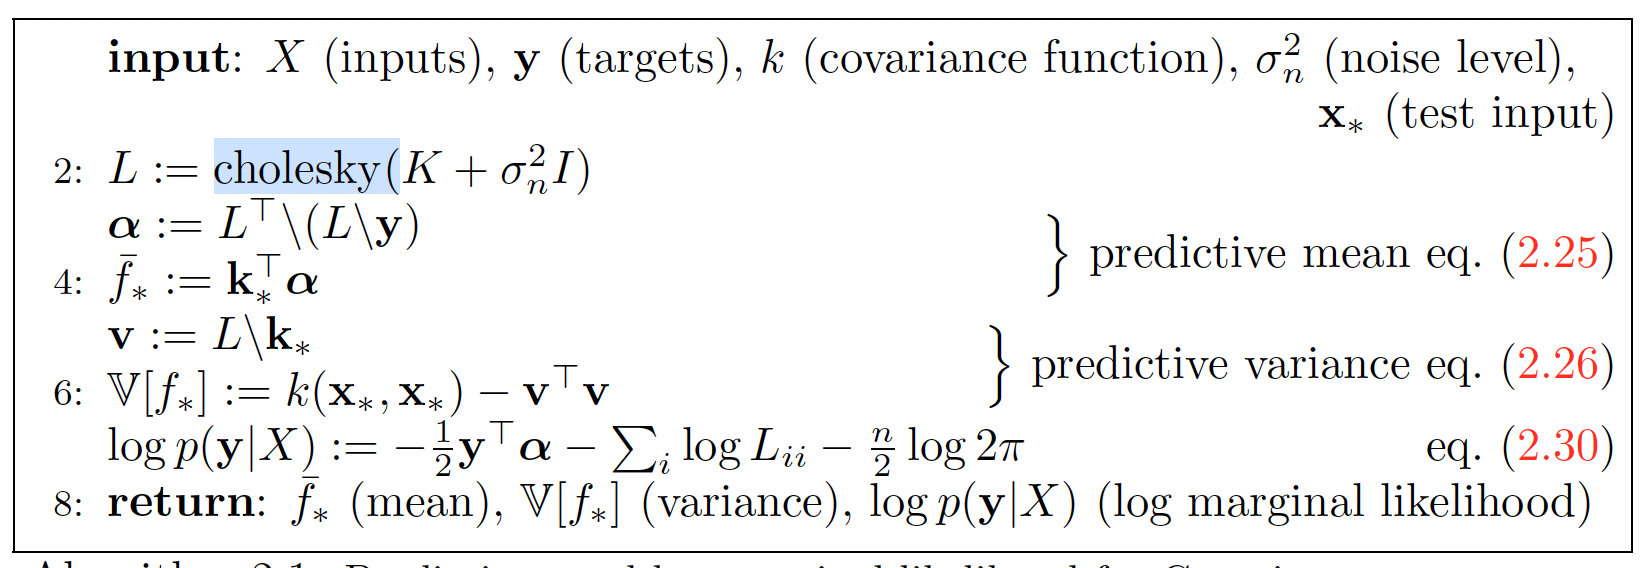

In [87]:
# Symmetry check
is_symmetric = torch.allclose(K_train_train, K_train_train.T, atol=1e-6)

# Check for positive definiteness using eigenvalues
eigenvalues = torch.linalg.eigvalsh(K_train_train + torch.eye(K_train_train.shape[0]) * torch.absolute(torch.min(torch.linalg.eigvalsh(K_train_train), torch.tensor(0.0))) * 5)
is_positive_definite = torch.all(eigenvalues > 0)

print(f"Is Symmetric: {is_symmetric}")
print(f"Is Positive Definite: {is_positive_definite}")

Is Symmetric: True
Is Positive Definite: True


In [172]:
# Stabilise: # Cholesky factorisation
# L_cholesky = torch.cholesky(K_train_train + torch.eye(K_train_train.shape[0]) * torch.absolute(torch.min(torch.linalg.eigvalsh(K_train_train), torch.tensor(0.0))) * 2)

L = torch.cholesky(K_train_train)
# flatten y to one dimension

# Shape n_obs x 1 - torch.Size([100, 1])
alpha = torch.cholesky_solve(y_train.reshape(-1, 1), L)
mean_pred = K_train_test.T.mm(alpha)

# Wrong: v = L.div(K_train_test)
# Step 3: Solve for v = L^-1 * K(X_*, X) (i.e., solve LV = K(X_*, X))
v = torch.linalg.solve_triangular(L, K_train_test, upper = False)
# Covariance matrix - torch.Size([800, 800])
covar = K_test_test - v.T.mm(v)

In [183]:
posterior = torch.distributions.MultivariateNormal(loc = mean_pred.squeeze(), covariance_matrix = covar + 1e-6 * torch.eye(covar.size(0)))

In [211]:
sample = posterior.sample()

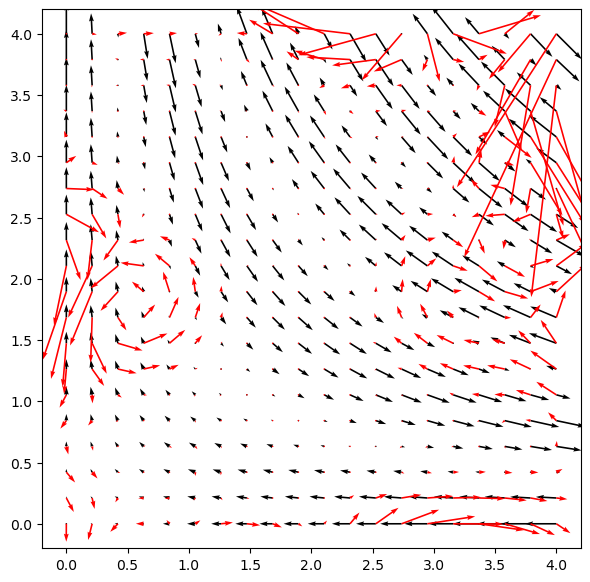

In [212]:
# creating plot
fig, ax = plt.subplots(figsize = (7, 7))

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, F1, F2)
ax.quiver(X1, X2, sample[0:400].reshape(20, 20), sample[400:].reshape(20, 20), color = 'red')

ax.set_aspect('equal')
 
# show plot
plt.show()

In [151]:
covar += 1e-6 * torch.eye(covar.size(0))
L_predictive = torch.linalg.cholesky(covar)

# Number of samples
n_samples = 5

# Generate multiple standard normal samples
z = torch.randn(mean_pred.size(0), n_samples).double()  # Each column is a standard normal vector

samples = mean_pred.unsqueeze(1) + torch.matmul(L_predictive, z.to(torch.float64))

RuntimeError: The size of tensor a (100) must match the size of tensor b (5) at non-singleton dimension 2

In [162]:
torch.distributions.multivariate_normal(loc = mean_pred, covariance_matrix = covar)

TypeError: 'module' object is not callable